<a href="https://colab.research.google.com/github/halynadanchukda/Ecommerce-Analysis/blob/main/Where_Customers_Come_From_and_What_They_Buy%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Where Customers Come From and What They Buy?


This project analyzes where customers come from and what they buy using data on sessions, accounts, and orders from 100+ countries. It identifies top markets, product categories, devices, and traffic sources, explores differences between registered and unregistered users, and studies sales patterns by weekdays. Both descriptive analytics and statistical tests (correlation, ANOVA) are applied to reveal key drivers of sales and opportunities for business growth.

##Imports

In [ ]:
#renew google-cloud-bigquery library
!pip install --upgrade google-cloud-bigquery

In [ ]:
#Import neccessary libraries:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kendalltau, mannwhitneyu, f_oneway

##SQL-Query

#### Connecting to data

In [ ]:
#Authentication
auth.authenticate_user()

#Creating a client for BigQuery
client = bigquery.Client(project="data-analytics-mate")

#SQL-query
query = """
WITH
  sessions AS (
  SELECT
    ga_session_id,
    continent,
    country,
    browser,
    device,
    mobile_model_name,
    operating_system,
    language AS browser_language,
    channel AS traffic_channel,
    medium AS traffic_source,
    date AS order_date
  FROM
    DA.session AS s
  JOIN
    DA.session_params AS sp
  USING
    (ga_session_id) ),

  accounts AS (
  SELECT
    ga_session_id,
    id AS user_id,
    is_verified,
    is_unsubscribed
  FROM
    DA.account_session AS acs
  JOIN
    DA.account AS a
  ON
    acs.account_id = a.id ),

  orders AS (
  SELECT
    ga_session_id,
    item_id,
    category AS product_category,
    name AS product_name,
    price,
    short_description
  FROM
    DA.order AS o
  JOIN
    DA.product AS p
  USING
    (item_id) )

SELECT
  order_date,
  sessions.ga_session_id,
  continent,
  country,
  device,
  browser,
  mobile_model_name,
  operating_system,
  browser_language,
  traffic_source,
  traffic_channel,
  user_id,
  is_verified,
  is_unsubscribed,
  product_category,
  product_name,
  price,
  short_description
FROM
  sessions
LEFT JOIN
  orders
ON
  sessions.ga_session_id = orders.ga_session_id
LEFT JOIN
  accounts
ON
  sessions.ga_session_id = accounts.ga_session_id
ORDER BY
  order_date DESC
"""

#Execution of an SQL query
query_job = client.query(query)
results = query_job.result()

#### Description of SQL-query:
The dataset is built around three main entities: **sessions, accounts and orders**.

The use of **CTE** is due to two reasons: enabling query optimization and improving readability.

The first CTE - `sessions` - contains data about all the user sessions
The second CTE - `accounts` - contains data about registered users linked to those sessions
The third CTE - `orders` - contains data about all the orders placed during sessions, both from registered and unregistered users.

Therefore, the resulting dataset has the following columns:
- `order_date`	- date the order was placed;
- `ga_session_id`	- unique session identfier;
- `continent`	- user's continent;
- `country`	- user's country;
- `device` - device type;
- `browser` - browser name;
- `mobile_model_name`	- model name of the mobile device;
- `operating_system` - operating system name;
- `browser_language` - language set in the browser (if available);
- `traffic_source` - specific origin of the traffic;
- `traffic_channel`	- channel through which the user arrived;
- `user_id`	- unique identifier of the registered user (if available);
- `is_verified`	- whether the account is verified (1 - yes, 0 - no);
- `is_unsubscribed`	- whether the account is unsubscribed (1 - yes, 0 - no);
- `product_category` -category of the product purchased;
- `product_name`	- ordered product name;
- `price`	- product price;
- `short_description` - short description of the product

##Python

### Data description

#### DataFrame

In [ ]:
#Converting results to a DataFrame

# Create a copy of dataset for all the further calculations
df_original = results.to_dataframe()
df = df_original.copy()
#Output
df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,browser_language,traffic_source,traffic_channel,user_id,is_verified,is_unsubscribed,product_category,product_name,price,short_description
0,2021-01-31,6195513792,Americas,United States,desktop,Chrome,Safari,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-31,6119103917,(not set),(not set),desktop,Chrome,Safari,Macintosh,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
2,2021-01-31,2089229050,Americas,United States,mobile,Chrome,<Other>,Web,en-ca,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2021-01-31,7582188455,Europe,Ukraine,desktop,Chrome,ChromeBook,<Other>,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
4,2021-01-31,2893825748,Asia,United Arab Emirates,desktop,Chrome,Chrome,Web,en-us,referral,Paid Search,<NA>,<NA>,<NA>,None,None,NaN,None


#### Data description
- The dataset contains `18 columns` and `349,545 rows`
- There are `5 numeric columns` ('ga_session_id',
'user_id', 'is_verified', 'is_unsubscribed', 'price'), but only 'price' column is relevant for calculations.
- There are `12 categorial` columns: ('continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'browser_language',
'traffic_source', 'traffic_channel', 'product_category', 'product_name', 'short_description')
- There is `1 dbdate` ('order_date'). This column should be transformed into datetime for further analysis.
- The dataset covers a time span of `91 days` from **2020-11-01** to **2021-01-31**
- Geography is wide and covers `108 countries` and `6 continents`, however there missing values marked as 'not set'
- `Devices` have 3 categories: 'desktop', 'mobile', 'tablet'
- There are `6 browsers and operating_systems`, 5 main categories and 1 marked as 'other'
- There are `6 traffic sources` and `5 traffic channels`
- Products can be divided into unique `14 categories`
- Whitin this dataset each buyer places one order for only one item. This means that the number of orders can be calculated directly from the number product_name columns.

#### Data Quality
- Total amount of unique sessions - `349,545`.
- There are significantly more session without orders - `316,007`, than sessions with orders - `33,538` . That's why there are missing(N/A) values in columns 'product_category',	'product_name', 'price', 'short_description', which is `90.4% ` of all data
- There are `27,945` registered users.
- There are `321,600` session without registered users, so there are missing(N/A) values in columns 'user_id', 'is_verified', 'is_unsubscribed', which is `92%` of all data
- Not all sessions have data about their browser language, therefore there are `114,266` missing(N/A) values in this column, which is `32.7%` of all data

In [ ]:
# Transform order_date into datetime
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
# Data frame composition (size, column types, missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   browser_language   235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  traffic_channel    349545 non-null  object 
 11  user_id            27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  product_category   33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [ ]:
# Missing values in columns
df.isna().sum()

,0
order_date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
browser_language,114266
traffic_source,0


In [ ]:
# Share of missing values in columns
df.isna().sum() / df.shape[0]

,0
order_date,0.000000
ga_session_id,0.000000
continent,0.000000
country,0.000000
device,0.000000
browser,0.000000
mobile_model_name,0.000000
operating_system,0.000000
browser_language,0.326899
traffic_source,0.000000


In [ ]:
# Transform ga_session_id, user_id, is_verified, is_unsubscribed into objects, since they're not needed in calculations
df['ga_session_id'] = df['ga_session_id'].astype(object)
df['user_id'] = df['user_id'].astype(object)
df['is_verified'] = df['is_verified'].astype(object)
df['is_unsubscribed'] = df['is_unsubscribed'].astype(object)

In [ ]:
# Price of products statistics
df.describe()

,price
count,33538.000000
mean,953.298679
std,1317.001775
min,3.000000
25%,170.000000
50%,445.000000
75%,1195.000000
max,9585.000000


In [ ]:
# Time span of dataset
maximum_date = df['order_date'].max()
minimum_date = df['order_date'].min()
print(f"First session: {minimum_date}, latest session: {maximum_date}, time range: {maximum_date - minimum_date}")

First session: 2020-11-01, latest session: 2021-01-31, time range: 91 days, 0:00:00


In [ ]:
#Unique values and unique values count
print(f"Continent unique values - {df['continent'].nunique()}: {df['continent'].unique()}")
print(f"Country unique values - {df['country'].nunique()}")
print(f"Device unique values - {df['device'].nunique()}: {df['device'].unique()}")
print(f"Browser unique values - {df['browser'].nunique()}: {df['browser'].unique()}")
print(f"Operating_system unique values - {df['operating_system'].nunique()}: {df['operating_system'].unique()}")
print(f"Traffic_source unique values - {df['traffic_source'].nunique()}: {df['traffic_source'].unique()}")
print(f"Traffic_channel unique values - {df['traffic_channel'].nunique()}: {df['traffic_channel'].unique()}")
print(f"Categories unique values - {df['product_category'].nunique()}: {df['product_category'].unique()}")

Continent unique values - 6: ['Americas' '(not set)' 'Europe' 'Asia' 'Oceania' 'Africa']
Country unique values - 108
Device unique values - 3: ['desktop' 'mobile' 'tablet']
Browser unique values - 6: ['Chrome' 'Safari' 'Edge' '<Other>' 'Android Webview' 'Firefox']
Operating_system unique values - 6: ['Web' 'Macintosh' '<Other>' 'iOS' 'Windows' 'Android']
Traffic_source unique values - 6: ['organic' 'referral' 'cpc' '<Other>' '(none)' '(data deleted)']
Traffic_channel unique values - 5: ['Organic Search' 'Paid Search' 'Direct' 'Undefined' 'Social Search']
Categories unique values - 14: [None 'Bookcases & shelving units' 'Cabinets & cupboards'
 'Outdoor furniture' 'Sofas & armchairs' 'Chairs' "Children's furniture"
 'Beds' 'Tables & desks' 'Bar furniture' 'Café furniture'
 'Chests of drawers & drawer units' 'Room dividers' 'Nursery furniture'
 'Sideboards, buffets & console tables']


### Section 1. Comprehensive Sales Analysis by Markets, Categories, Channels and Devices

####On which continents (top 3) and in which countries (top 5) does our company have the highest sales? The highest number of orders?

The top 3 continents by both orders count and total sales are Americas, Asia, and Europe.

At the country level, the top 5 markets are the United States, India, Canada, the United Kingdom, and France.

Therefore, regions with the highest order volumes also provide the highest revenue, so we can assume that there is a strong positive relationship between the number of orders and overall sales.

In [ ]:
# Top 3 Continents by Revenue
top_3_continents_revenue = df.groupby('continent')['price'].sum().reset_index().sort_values(by='price', ascending=False).head(3).rename(columns={'price': 'revenue'})
top_3_continents_revenue

,continent,revenue
2,Americas,17665280.0
3,Asia,7601298.3
4,Europe,5934624.2


Text(0.5, 1.0, 'Top 3 Continents by Revenue')

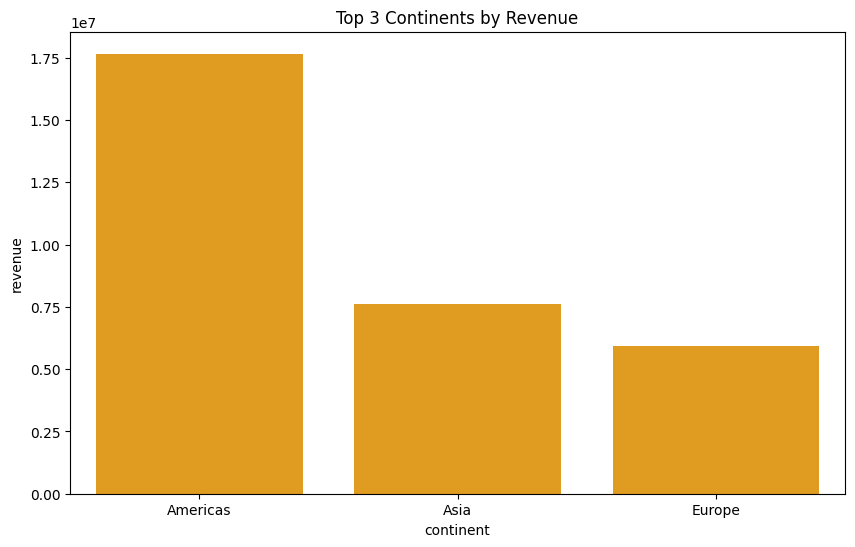

In [ ]:
# Bar plot for Top 3 Continents by Revenue
plt.figure(figsize=(10,6))
sns.barplot(data=top_3_continents_revenue, x='continent', y='revenue', color='orange')
plt.title('Top 3 Continents by Revenue')

In [ ]:
# Top 3 continents by orders count
top_3_continents_orders = df.groupby('continent')['product_name'].count().reset_index().sort_values(by='product_name', ascending=False).head(3).rename(columns={'product_name': 'products_count'})
top_3_continents_orders

,continent,products_count
2,Americas,18553
3,Asia,7950
4,Europe,6261


Text(0.5, 1.0, 'Top 3 Continents by Orders')

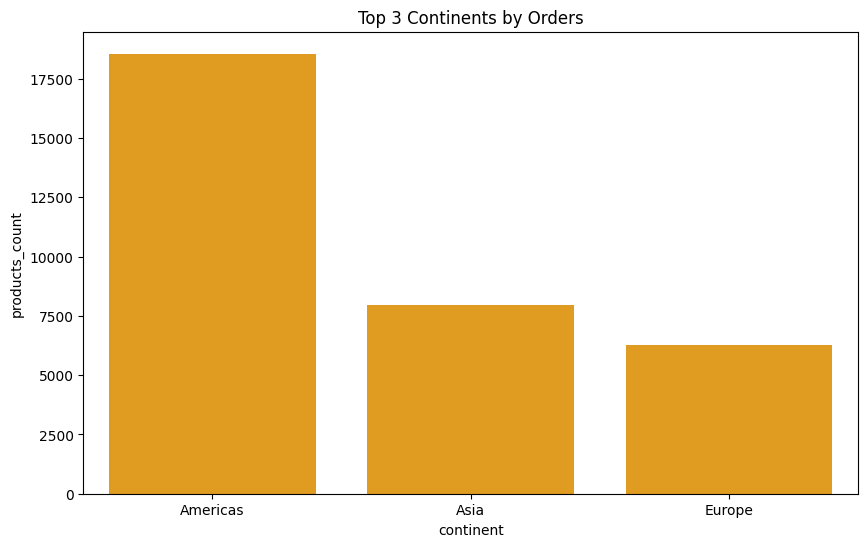

In [ ]:
# Bar plot for Top 3 continents by orders
plt.figure(figsize=(10,6))
sns.barplot(data=top_3_continents_orders, x='continent', y='products_count', color='orange')
plt.title('Top 3 Continents by Orders')

In [ ]:
# Top 5 countries by revenue
top_5_countries_revenue  = df.groupby('country')['price'].sum().reset_index().sort_values(by='price', ascending=False).head(5).rename(columns={'price': 'revenue'})
top_5_countries_revenue

,country,revenue
104,United States,13943553.9
43,India,2809762.0
18,Canada,2437921.0
103,United Kingdom,938317.9
33,France,710692.8


Text(0.5, 1.0, 'Top 5 Countries by Revenue')

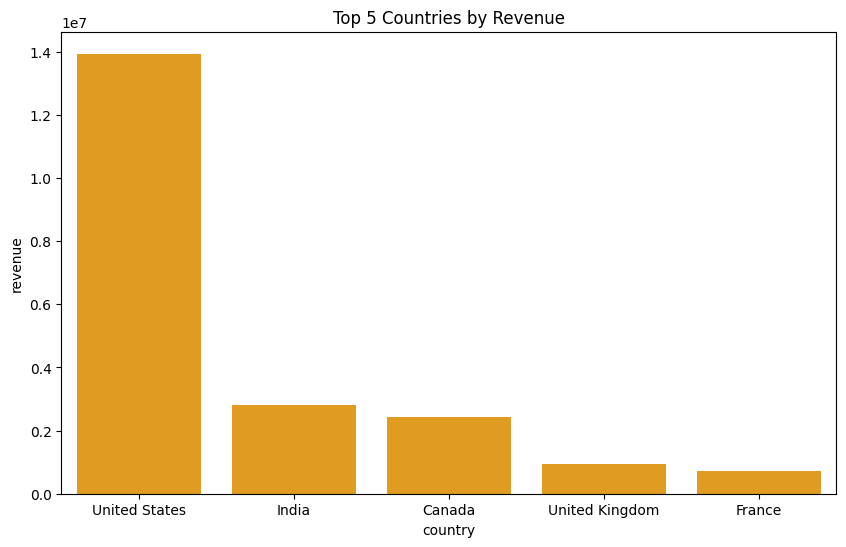

In [ ]:
# Bar plot for Top 5 countries by revenue
plt.figure(figsize=(10,6))
sns.barplot(data=top_5_countries_revenue, x='country', y='revenue', color='orange')
plt.title('Top 5 Countries by Revenue')

In [ ]:
# Top 5 countries by orders count
top_5_countries_orders = df.groupby('country')['product_name'].count().reset_index().sort_values(by='product_name', ascending=False).head(5).rename(columns={'product_name': 'products_count'})
top_5_countries_orders

,country,products_count
104,United States,14673
43,India,3029
18,Canada,2560
103,United Kingdom,1029
33,France,678


Text(0.5, 1.0, 'Top 5 Countries by Orders')

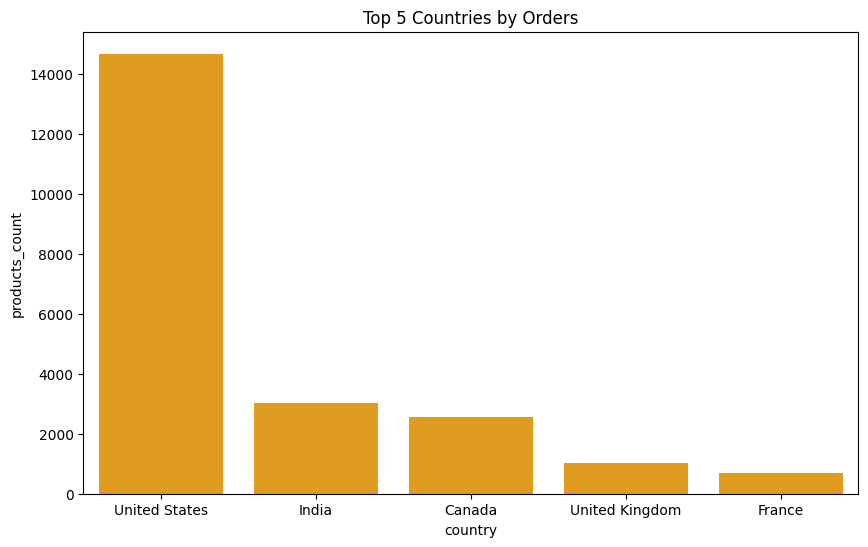

In [ ]:
# Bar plot for Top 5 countries by orders
plt.figure(figsize=(10,6))
sns.barplot(data=top_5_countries_orders, x='country', y='products_count', color='orange')
plt.title('Top 5 Countries by Orders')

#### What are the top 10 product categories by total sales? What are the top 10 product categories in the country with the highest sales, and does the situation differ from the overall picture?

All top-10 categories by revenue are as well top categories by sales, which confirms a positive link between sales volumes and revenue.

However, their positions in the rating differ: 'Chairs' generate the highest number of sales, but it is placed second in the revenue rating. On the other hand, 'Bookcases & shelving units'  bring a most sales, but they are fourth by revenue. This difference shows that despite the number of sales, product price impacts revenue ranking.

When it comes to the top country by sales - the US - rating of categories is the same as the rank in total, which shows that this country's trend for sales and the global trend are the same.

Text(0.5, 1.0, 'Top 10 Categories by Orders')

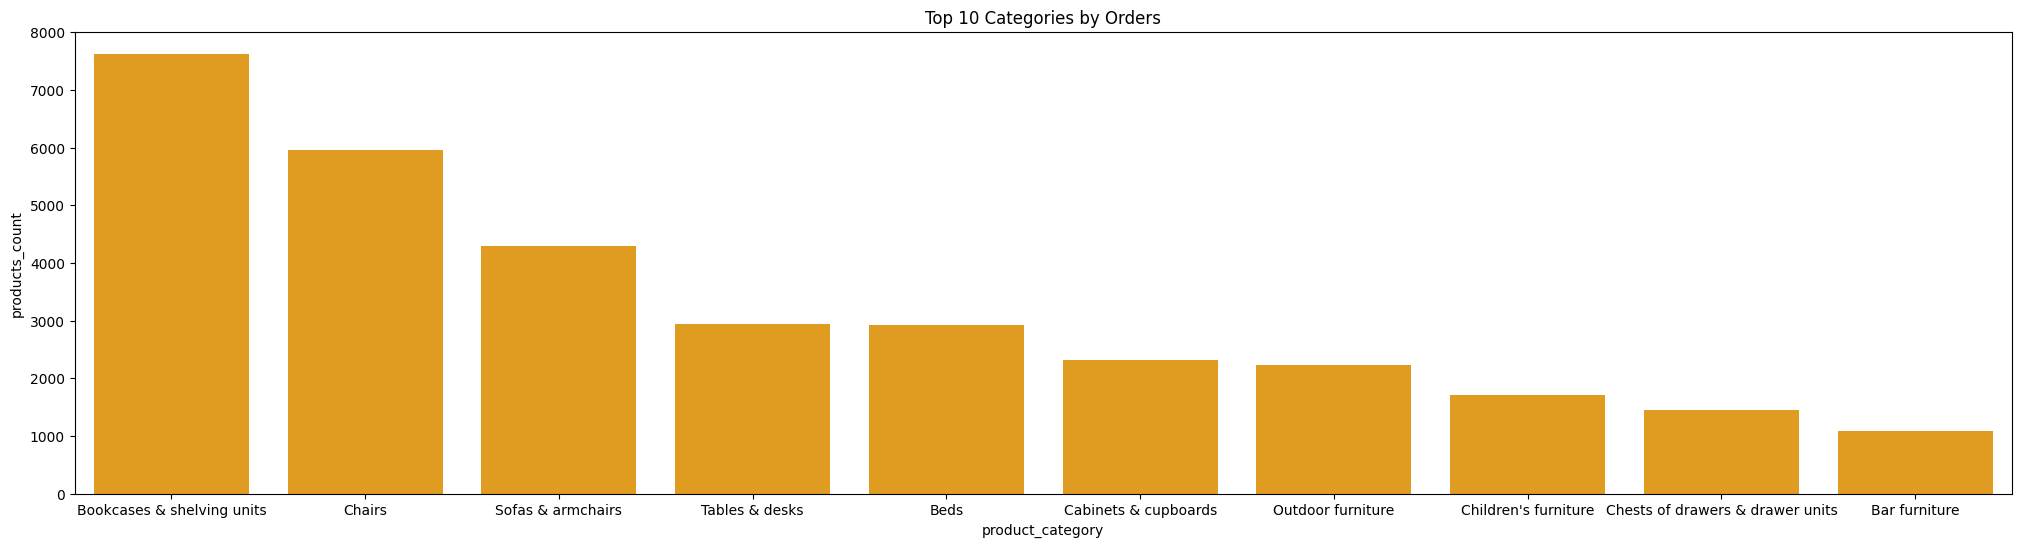

In [ ]:
# Top 10 product categories by orders
top_10_product_categories = df.groupby('product_category')['product_name'].count().reset_index().sort_values(by='product_name', ascending=False).head(10).rename(columns={'product_name': 'products_count'})
top_10_product_categories

# Bar plot for Top 10 Categories by Orders
plt.figure(figsize=(25,6))
sns.barplot(data=top_10_product_categories, x='product_category', y='products_count', color='orange')
plt.title('Top 10 Categories by Orders')

Text(0.5, 1.0, 'Top 10 Categories by Revenue')

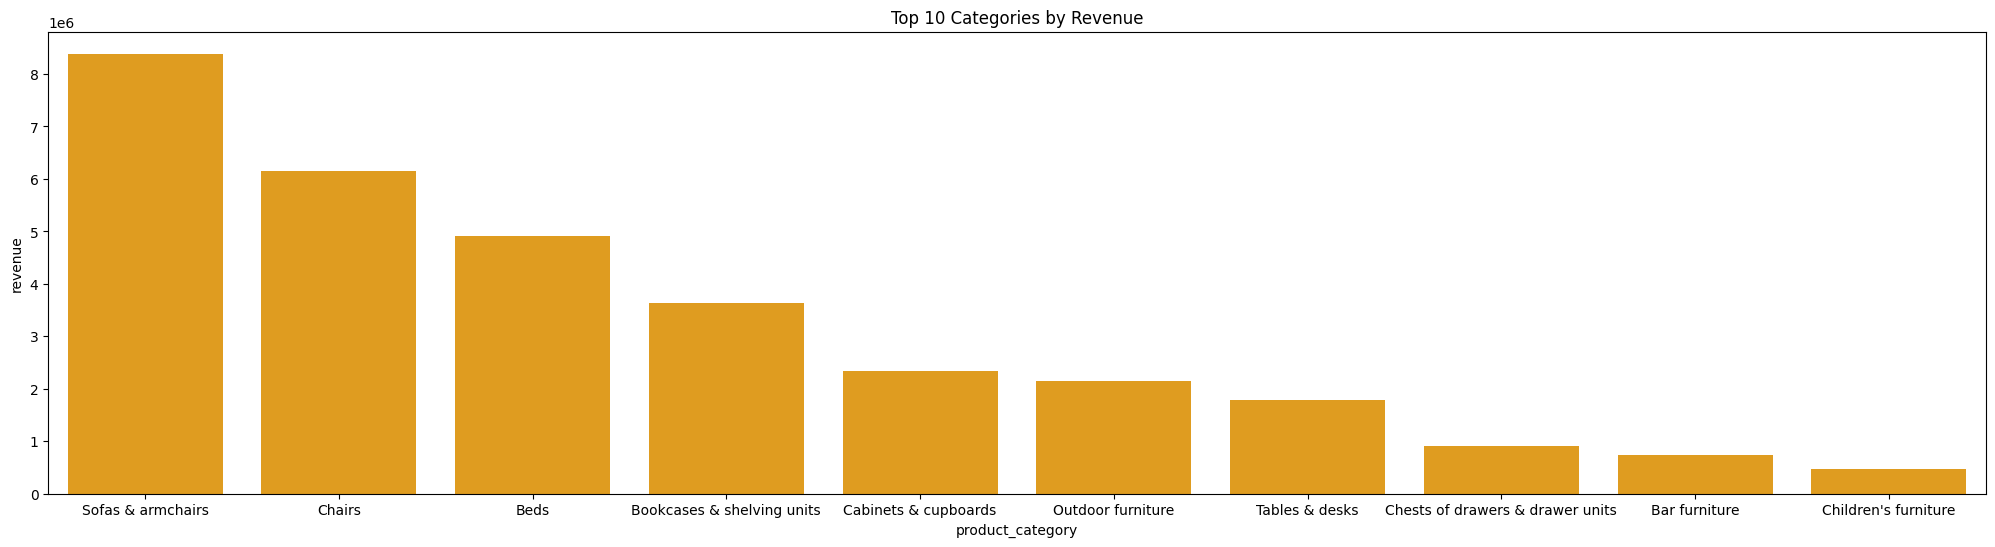

In [ ]:
# Top 10 product categories by revenue
top_10_product_categories = df.groupby('product_category')['price'].sum().reset_index().sort_values(by='price', ascending=False).head(10).rename(columns={'price': 'revenue'})
top_10_product_categories

# Bar plot for Top 10 Categories by Revenue
plt.figure(figsize=(25,6))
sns.barplot(data=top_10_product_categories, x='product_category', y='revenue', color='orange')
plt.title('Top 10 Categories by Revenue')

Text(0.5, 1.0, 'Top 10 Categories by Revenue in Top Country')

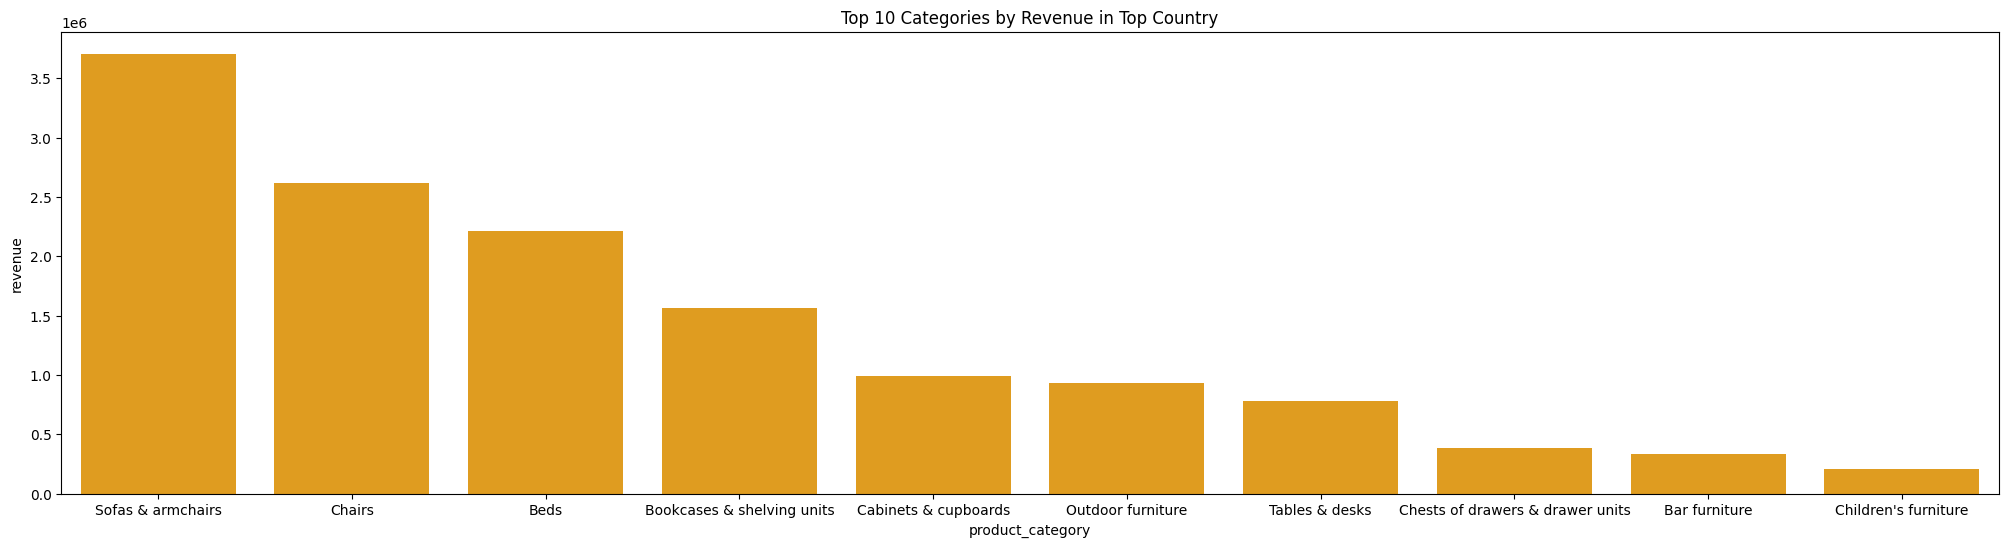

In [ ]:
#Top country
top_country = df.groupby('country')['product_name'].count().reset_index().sort_values(by='product_name', ascending=False).iloc[0, 0]

# Top 10 product categories in Top Country (the USA) by revenue
top_10_product_categories_in_top_country = df[df['country'] == top_country].groupby('product_category')['price'].sum().reset_index().sort_values(by='price', ascending=False).head(10).rename(columns={'price': 'revenue'})
top_10_product_categories_in_top_country

# Bar plot for Top 10 Categories by Revenue
plt.figure(figsize=(25,6))
sns.barplot(data=top_10_product_categories_in_top_country, x='product_category', y='revenue', color='orange')
plt.title('Top 10 Categories by Revenue in Top Country')

####% What percentage of total sales are generated by sales from different devices?

Most sales come from desktop devices (59%), showing a clear desktop dominance. Mobile share is still significant - about 38% of sales, but tablets bring only 2% of sales which means that this channel is not very profitable.

Among movile models, the most profitable one is 'Chrome', which prings 28% of revenue, closely followed by 'Safari' and 'iPhone', while othersgenerate less revenue. But it's important to known that the sare of 'Other' mobile models is quite big - 20%

In [ ]:
# Share of revenue per device
device_sales_share = round(df.groupby('device')['price'].sum() / df['price'].sum() * 100, 2).reset_index().rename(columns={"price":"share_from_total_sales, %"}).sort_values(by='share_from_total_sales, %', ascending=False)
device_sales_share

,device,"share_from_total_sales, %"
0,desktop,59.00
1,mobile,38.73
2,tablet,2.26


In [ ]:
# Share of revenue per mobile model
mobile_model_sales_share = round(df.groupby('mobile_model_name')['price'].sum() / df['price'].sum() * 100, 2).reset_index().rename(columns={"price":"share_from_total_sales, %"}).sort_values(by='share_from_total_sales, %', ascending=False)
mobile_model_sales_share

,mobile_model_name,"share_from_total_sales, %"
1,Chrome,27.84
0,<Other>,20.44
7,Safari,20.30
9,iPhone,20.08
2,ChromeBook,5.73
3,Edge,2.18
8,iPad,1.40
4,Firefox,1.32
6,Pixel 4 XL,0.37
5,Pixel 3,0.34


#### What percentage of total sales are generated through traffic channels?


In terms of traffic sources, most sales come from organic search (36%) and direct (23), which means that most revenue come from unpaid sources. However, paid search still contributes significantly (23%) and cannot be ignored. At the same time, Social Search and Undefined have significantly less impact on revenue.

As for traffic sources, most sales are generated from organic search as well, and a significant share (23%) belongs to direct traffic (here marked as 'none').Referral traffic (18%) shows great partnerships results. Overall this shows good brend recognition and loyalty from customers.  However, CPC shows that paid search isn't as successful, providing only 6% of profit.

In [ ]:
# Share of revenue by traffic channel
traffic_channel_share = round(df.groupby('traffic_channel')['price'].sum() / df['price'].sum() * 100, 2).reset_index().rename(columns={"price":"share_from_total_sales, %"}).sort_values(by='share_from_total_sales, %', ascending=False)
traffic_channel_share

,traffic_channel,"share_from_total_sales, %"
1,Organic Search,35.76
2,Paid Search,26.62
0,Direct,23.44
3,Social Search,7.92
4,Undefined,6.26


In [ ]:
# Share of revenue by traffic source
traffic_source_share = round(df.groupby('traffic_source')['price'].sum() / df['price'].sum() * 100, 2).reset_index().rename(columns={"price":"share_from_total_sales, %"}).sort_values(by='share_from_total_sales, %', ascending=False)
traffic_source_share

,traffic_source,"share_from_total_sales, %"
4,organic,34.20
1,(none),23.44
5,referral,17.65
2,<Other>,14.05
0,(data deleted),6.39
3,cpc,4.27


#### What is the average check for a continent/country?

The average check is 953.3\$. The top countries by average check are Palestine, Bulgaria, Albania, Venezuela, and Kenia. Top continets are Oceania and Africa, but the biggest average check belongs to group marked as “not set”.

This shows that top countries and top continents by sales volume are not the same as those with the highest average check. In practice, this can mean that while we have countries and continents with biggest sales volumes, we have some countries, where customers can pay significantly more per purchase. For example Palestine's, Bulgaria's and Albania's average ckecks are significantly bigger than the global average check, highlighting an opportunity to position premium products in such markets.

In [ ]:
# Global average check
global_average_check = round(df['price'].mean(), 2)
global_average_check

np.float64(953.3)

In [ ]:
# Top 3 continents by average check
average_check_by_continent = round(df.groupby('continent')['price'].mean(), 2).reset_index().sort_values(by='price', ascending=False).head(3).rename(columns={'price': 'average check'})
average_check_by_continent

,continent,average check
0,(not set),1043.20
5,Oceania,1003.38
1,Africa,977.08


In [ ]:
# Top 5 countries by average check
average_check_by_country = round(df.groupby('country')['price'].mean(), 2).reset_index().sort_values(by='price', ascending=False).head(5).rename(columns={'price': 'average check'})
average_check_by_country

,country,average check
75,Palestine,1747.69
16,Bulgaria,1518.11
1,Albania,1401.50
106,Venezuela,1396.77
53,Kenya,1373.48


#### Are the sales by days of week the same, or do they have differences?

The average revenue vary significantly depending on the day of week. The highest sales are on Tuesday and Wednesday, while on weekend are lower. It indicated the difference in user behavior on weekdays and weekends.

/tmp/ipython-input-890091364.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_revenue = df.groupby('weekday')['price'].sum().reset_index().sort_values(by='weekday').rename(columns={'price': 'revenue'})


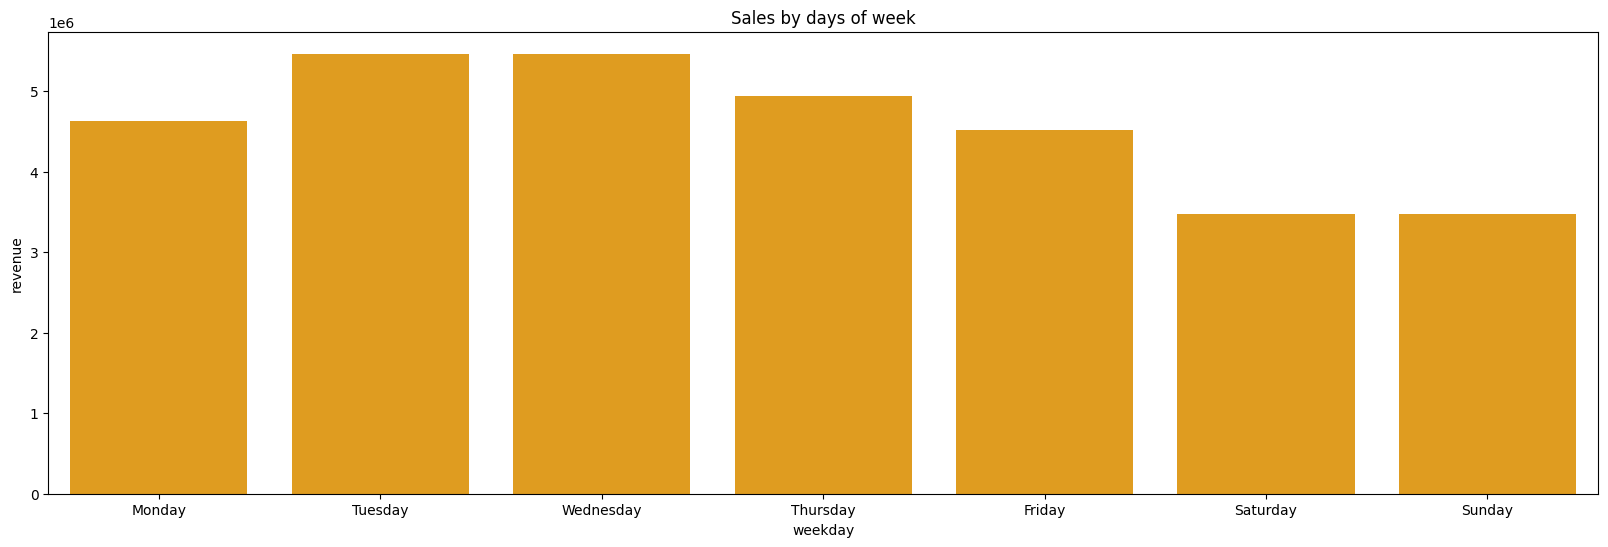

In [ ]:
# Order of days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Days of week
df['weekday'] = df['order_date'].dt.day_name()
df['weekday'] = pd.Categorical(df['weekday'], categories=days_order, ordered=True)

# Revenue by days of week
daily_revenue = df.groupby('weekday')['price'].sum().reset_index().sort_values(by='weekday').rename(columns={'price': 'revenue'})

# Line Plot
plt.figure(figsize=(20,6))
sns.barplot(data=daily_revenue, x="weekday", y="revenue", color='orange')
plt.title("Sales by days of week")
plt.show()

### Section 2. Sales dynamics

#### Daily total sales

Daily revenue shows clear fluctuations. Daily sales volumes mostly are within 200-500k, but there some outliers, such as 700k in December and January, which can be caused by6 holiday season, and low sales volumes in March, which can be caused either by post-holiday slowdown or incomplete data in that peroid of time

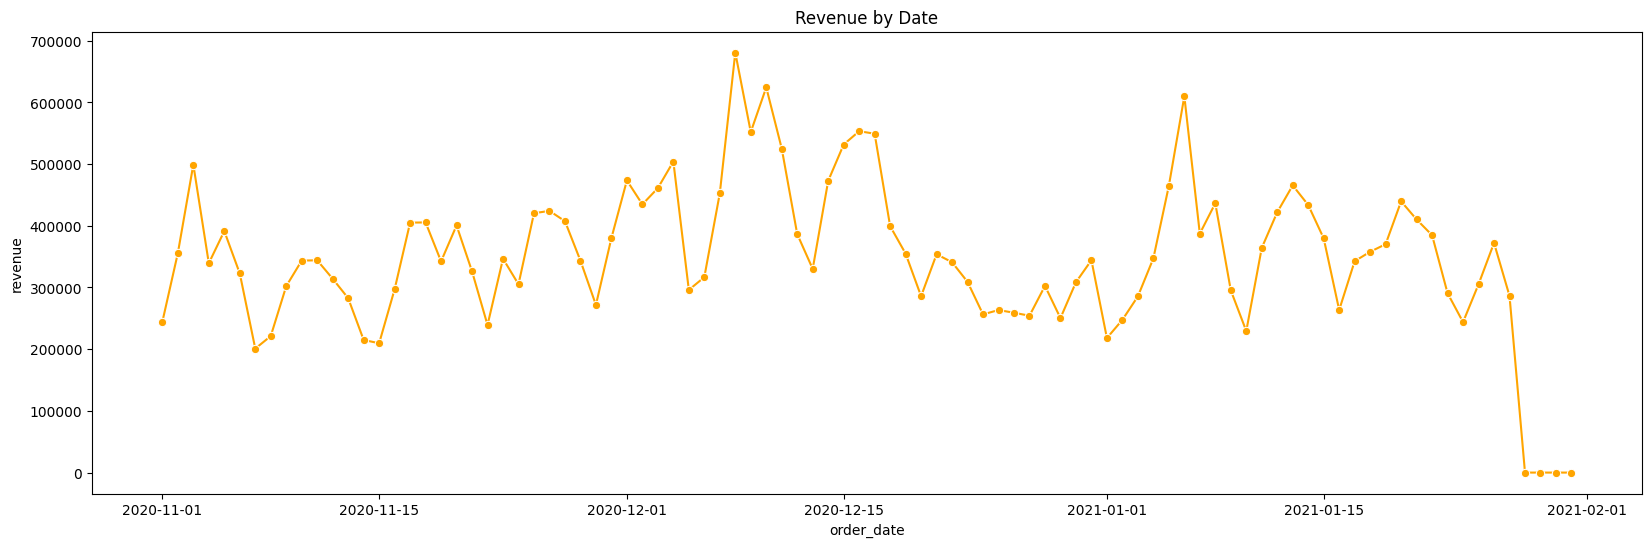

In [ ]:
# Global daily revenue
revenue_by_date = df.groupby('order_date')['price'].sum().reset_index().sort_values(by='order_date').rename(columns={'price': 'revenue'})

# Line plot
plt.figure(figsize=(20,6))
sns.lineplot(data=revenue_by_date, x="order_date", y="revenue", marker="o", color='orange')
plt.title("Revenue by Date")
plt.show()

#### Daily sales by continent (America, Asia, Europe).

Americas clearly dominate in sales, evenue in Europe and Asia remains in the lower range of \$50000-150000. Revenue trend in Americas almost identically repeats global trend,

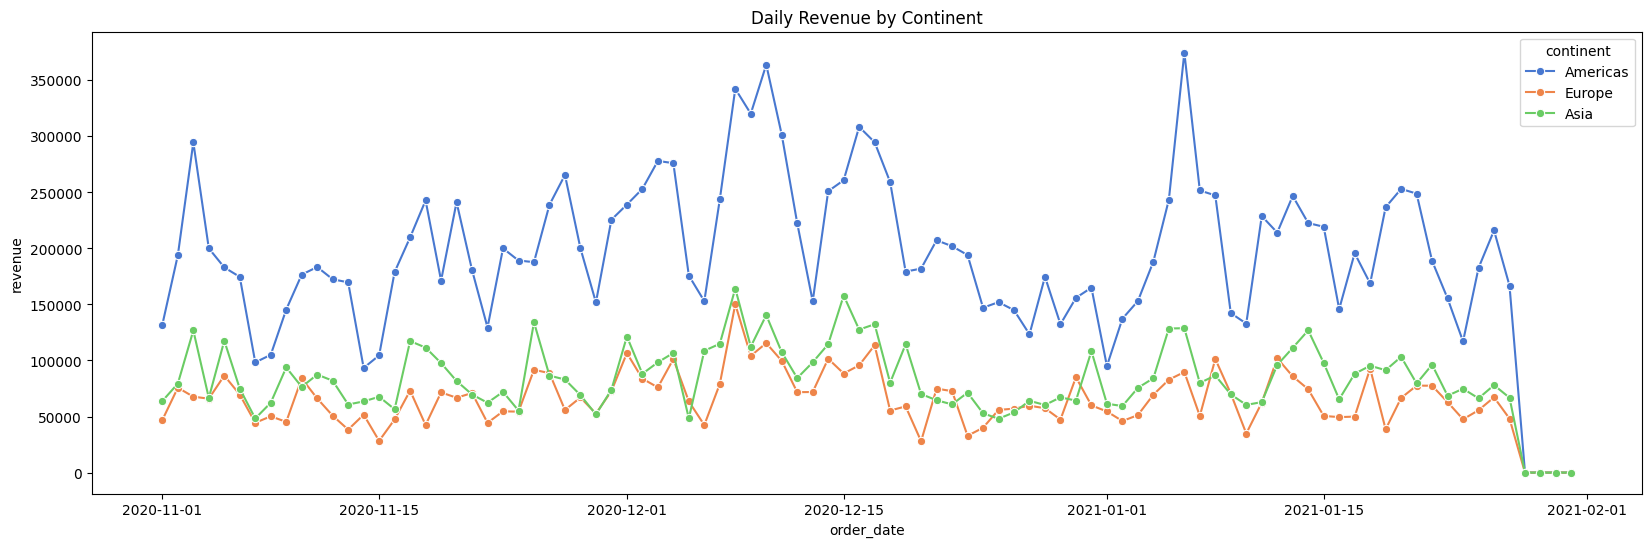

In [ ]:
# Top 3 continents by sales
top_continent = ['Americas', 'Asia', 'Europe']

# Daily revenue by continent
daily_revenue_by_continent = df[df['continent'].isin(top_continent )].groupby(['continent', 'order_date'])['price'].sum().reset_index().sort_values(by='order_date').rename(columns={'price': 'revenue'})

# Line Plot
plt.figure(figsize=(20,6))
sns.lineplot(data=daily_revenue_by_continent, x="order_date", y="revenue", hue='continent', marker="o", color='black', palette='muted')
plt.title("Daily Revenue by Continent")
plt.show()

#### Daily sales by device types.
It's clearly seen that desctrops have leading position in daily revenue generation, while mobiles takes second place, and tablets are almost invisible in overall sales and have almost no seasonal peaks

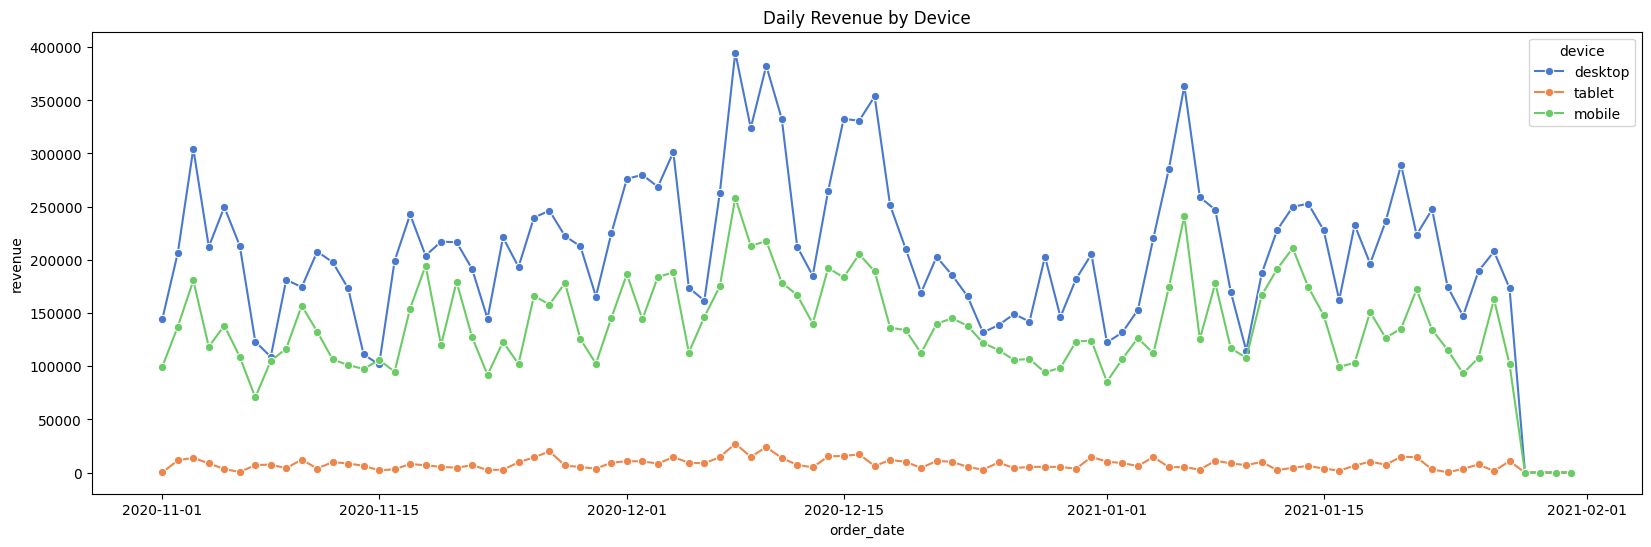

In [ ]:
# Daily revenue by device type
daily_revenue_by_device = df.groupby(['device', 'order_date'])['price'].sum().reset_index().sort_values(by='order_date').rename(columns={'price': 'revenue'})

# Line Plot
plt.figure(figsize=(20,6))
sns.lineplot(data=daily_revenue_by_device, x="order_date", y="revenue", hue='device', marker="o", palette='muted')
plt.title("Daily Revenue by Device")
plt.show()

#### Daily sales by traffic channels.
It's clearly seen that the main revenue is generated by three channels - Organic Search, Paid Search and Direct. Social Search and Undefined have a minor impact, but they also follow seasonal trends.

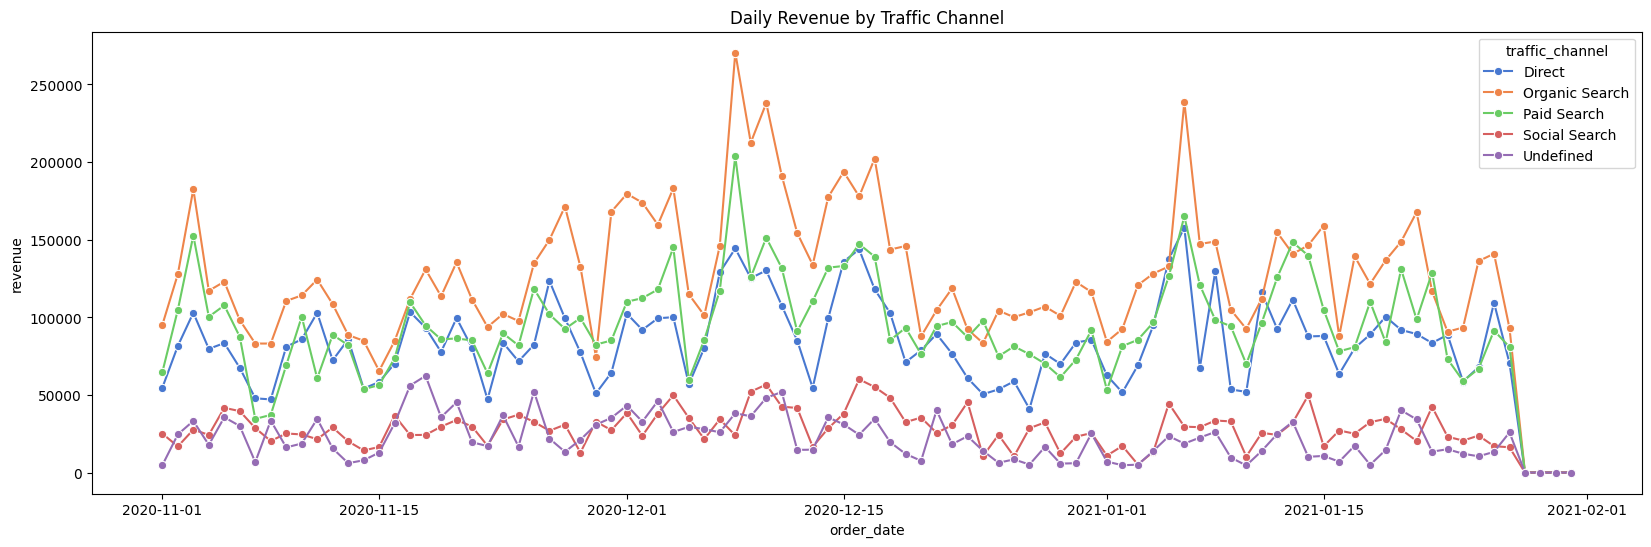

In [ ]:
# Daily revenue by traffic channel
daily_revenue_by_traffic_channel = df.groupby(['traffic_channel', 'order_date'])['price'].sum().reset_index().sort_values(by='order_date').rename(columns={'price': 'revenue'})

# Line Plot
plt.figure(figsize=(20,6))
sns.lineplot(data=daily_revenue_by_traffic_channel, x="order_date", y="revenue", hue='traffic_channel', marker="o", palette='muted')
plt.title("Daily Revenue by Traffic Channel")
plt.show()

### Section 3. Pivot tables

#### A pivot table showing total sales by product category (top 10 categories) in different countries (top 5 countries)

The USA is clearly the leading market across all the categories, while India, closely folowed by Canada, also generates much revenue. France and the UK contributes smaller, but steadily, which can mean that these countries have a good opportunity for further development.

In [ ]:
#Top 10 categories by revenue
top_10_categories = top_10_product_categories['product_category'].tolist()

# Top 5 countries by revenue
top_5_countries = top_5_countries_revenue['country'].tolist()

# Filtered Data Frame
data = df[(df['country'].isin(top_5_countries)) & (df['product_category'].isin(top_10_categories))]

# Pivot table
pivot = pd.pivot_table(data, values = 'price', index='product_category', columns='country', aggfunc='sum')
pivot

country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


<Axes: xlabel='country', ylabel='product_category'>

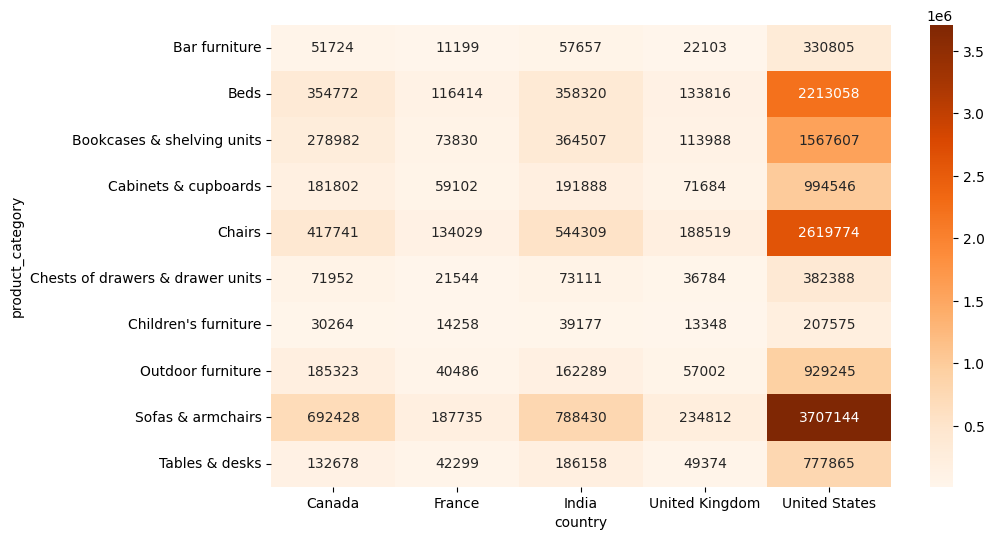

In [ ]:
#Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='Oranges', fmt=".0f", annot=True,)

#### A pivot table showing total sales for registered and unregistered users on different continents

It's clear that the unregistered users generate the vast majority of revenue across all the continents, while registered users contribute only to a small share of total revenue.

This indicates a missed opportunity for business, since most customers make purchases without creating accounts, which limits options for re-engagement. That's why business should focus more on encouraging users to create their accounts in the future.

In [ ]:
# Create a new column, where 1 is a registered user, and 0 - not registered user.
df['users_type'] = df['user_id'].notna().astype(int)

pivot_users = pd.pivot_table(df, values = 'price', index='continent', columns='users_type', aggfunc='sum')
pivot_users

users_type,0,1
continent,,
(not set),73233.4,834.0
Africa,302840.9,28390.1
Americas,16247700.4,1417579.6
Asia,6982233.3,619065.0
Europe,5441914.4,492709.8
Oceania,341290.2,23940.0


<Axes: xlabel='users_type', ylabel='continent'>

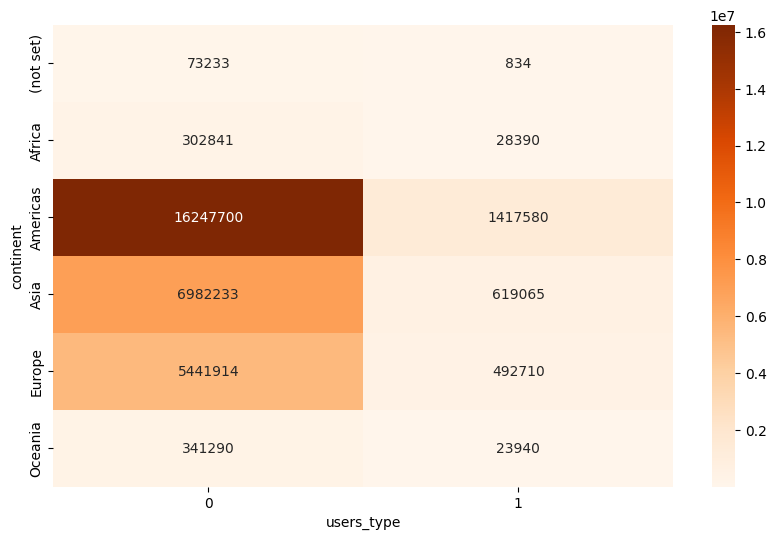

In [ ]:
#Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(pivot_users, cmap='Oranges', fmt=".0f", annot=True,)

### Section 4. Statistical analysis of correlations.

#### Do sessions and sales correlate by date?

It's clear that there is a statistically significant positive correlation between sessions and sales revenue, which means that with the increase in session, revenue also increases.

In [ ]:
# Sessions count and revenue by date
sessions_revenue_by_date = df.groupby('order_date').agg(sessions=('ga_session_id', 'count'), revenue=('price', 'sum')).reset_index()
sessions_revenue_by_date.head()

,order_date,sessions,revenue
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6


Text(0.5, 1.0, 'Sessions and Revenue')

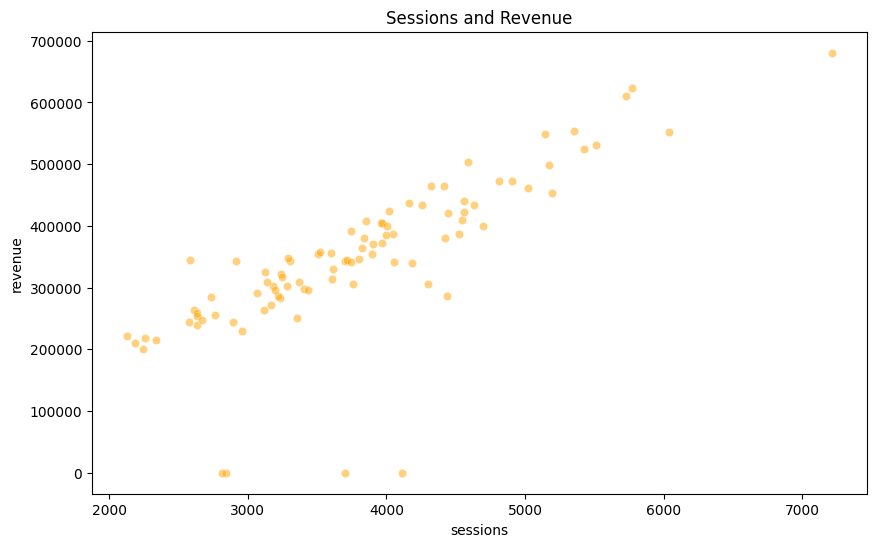

In [ ]:
# Scatterplot for visual correlation
plt.figure(figsize=(10,6))
sns.scatterplot(data=sessions_revenue_by_date, x='sessions', y='revenue', color='orange', alpha=0.5)
plt.title('Sessions and Revenue')

In [ ]:
# Check if the data is distributede normaly. Use Shapiro-Wilk test, because it works better for small samples

_, p_value_revenue = shapiro(sessions_revenue_by_date['revenue'])
if p_value_revenue < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is not normally distributed (reject H0)


In [ ]:
# Check if the data is distributede normaly

_, p_value_sessions = shapiro(sessions_revenue_by_date['sessions'])
if p_value_sessions < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is not normally distributed (reject H0)


Since data isn't normaly distributed, using of Kendall correlation test is  required, since it's more stable on small samples.

In [ ]:
# KLendall's Correlation
stat, p_value = kendalltau(sessions_revenue_by_date['revenue'], sessions_revenue_by_date['sessions'])
print(f'Kendall: {stat}, p_value: {p_value}')
if p_value < 0.05:
    print(f"There is a statistically significant correlation between revenue and amount of sessions")
else:
    print(f"There is no statistically significant correlation between revenue and amount of sessions")

Kendall: 0.717666930923723, p_value: 4.2515191569599826e-24
There is a statistically significant correlation between revenue and amount of sessions


#### Do average check and number of orders correlate?

There is no a statistically significant corelation between number of orders and average check


In [ ]:
# Average check and number of orders
average_check_and_orders = df.groupby('order_date').agg(average_check=('price', 'mean'), orders=('product_name', 'count')).reset_index()

# Remove n/a values, to ensure the proper work of statistical test
average_check_and_orders = average_check_and_orders.dropna(subset=['average_check', 'orders'])

Text(0.5, 1.0, 'Orders and Average Check')

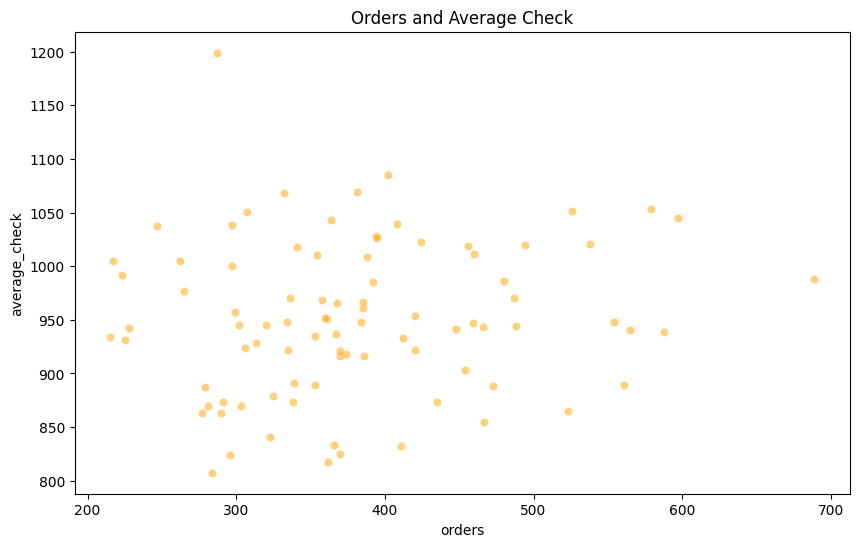

In [ ]:
# Scatterplot for visual correlation
plt.figure(figsize=(10,6))
sns.scatterplot(data=average_check_and_orders, x='orders', y='average_check', color='orange', alpha=0.5)
plt.title('Orders and Average Check')

In [ ]:
# Check if the data is distributede normaly. Use Shapiro-Wilk test, because it works better for small samples

_, p_value_revenue = shapiro(average_check_and_orders['orders'])
if p_value_revenue < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is not normally distributed (reject H0)


In [ ]:
# Check if the data is distributede normaly

_, p_value_sessions = shapiro(average_check_and_orders['average_check'])
if p_value_sessions < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is approximately normally distributed (there is no reason to reject H0).


Since the variable orders is not normally distributed (p < 0.05 according to Shapiro–Wilk), using of Kendall correlation test is  required, since it's more stable on small samples.

In [ ]:
# KLendall's Correlation
stat, p_value_average_ckeck = kendalltau(average_check_and_orders['orders'], average_check_and_orders['average_check'])
print(f'Kendall: {stat}, p_value: {p_value}')
if p_value_average_ckeck < 0.05:
  print(f"There is a statistically significant correlation between average check and amount of orders")
else:
  print(f"There is no statistically significant correlation between average check and amount of orders")

Kendall: 0.1058962399253798, p_value: 4.2515191569599826e-24
There is no statistically significant correlation between average check and amount of orders


### Section 5. Statistical analysis of differences between groups.

####  Is there a statistically significant difference between sales for each date of registered and unregistered users?

It's clear that unregistered users generate more revenue, as well as they make more orders. Therefore, although registered users are expected to be more engaged, in this case unregistered users are more active. This can be explained the facts, that some people don't like creating accounts, or that there is a large part of one-time buyers, so this question should be investigated further.

In [ ]:
# Revenue by date for unsubscribed users
unsubscribed_users = df[df['user_id'].isna()].groupby('order_date')['price'].sum().reset_index().rename(columns={'price': 'revenue'})
unsubscribed_users.head()

,order_date,revenue
0,2020-11-01,222745.5
1,2020-11-02,310550.0
2,2020-11-03,469829.1
3,2020-11-04,318204.9
4,2020-11-05,365942.0


In [ ]:
# Revenue by date for subscribed users
subscribed_users = df[df['user_id'].notna()].groupby('order_date')['price'].sum().reset_index().rename(columns={'price': 'revenue'})
subscribed_users.head()

,order_date,revenue
0,2020-11-01,21547.0
1,2020-11-02,44956.8
2,2020-11-03,29150.5
3,2020-11-04,20982.2
4,2020-11-05,25334.6


In [ ]:
# Check if data is normaly distributed. Use Shapirro-Wilk test, because it works better for small samples

_, p_value_subscribed = shapiro(subscribed_users['revenue'])
if p_value_subscribed < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is not normally distributed (reject H0)


In [ ]:
# Check if data is normaly distributed. Use Shapirro-Wilk test, because it works better for small samples

_, p_value_unsubscribed = shapiro(unsubscribed_users['revenue'])
if p_value_unsubscribed < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is not normally distributed (reject H0)


Since data is not normally distributed, using of Mann-Whitney test is requred

In [ ]:
# Check if there is difference between subscribed and unsubscribed users
u_stat, p_value = mannwhitneyu(unsubscribed_users['revenue'], subscribed_users['revenue'])
print(f'U-statistic: {u_stat}, p-value: {p_value}')
if p_value < 0.05:
    print("There is a statistically significant difference between versions A and B.")
else:
    print("No statistically significant difference between versions A and B.")

U-statistic: 7744.0, p-value: 3.8805185465235906e-26
There is a statistically significant difference between versions A and B.


#### Is there a statistically significant difference in average sales between days of the week?
Average sales vary significantly depending on the day of the week (F = 0.11, p = 0.013). This indicates that the day of the week is a factor that affects sales volume.

In [ ]:
# Check if the data is distributede normaly. Use Shapiro-Wilk test, because it works better for small samples

_, p_value_revenue = shapiro(daily_revenue['revenue'])
if p_value_revenue < 0.05:
  print(f"The data is not normally distributed (reject H0)")
else:
  print(f"The data is approximately normally distributed (there is no reason to reject H0).")

The data is approximately normally distributed (there is no reason to reject H0).


For this type of corelation test, using of ANOVA is required

In [ ]:
df_days_of_week = df.dropna(subset=['price'])

groups = [df_days_of_week[df_days_of_week['weekday'] == day]['price'] for day in df['weekday'].unique()]
f_stat, p_value_anova = f_oneway(*groups)
print(f'Anova: {stat}, p_value: {p_value_anova}')
if p_value_anova < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("No statistically significant difference between the groups.")

Anova: 0.1058962399253798, p_value: 0.012830927408263101
There is a statistically significant difference between the groups.


##Conclusions

Analysis of session, order, and user data revealed key sales drivers and opportunities for growth. The main markets are America, Asia, and Europe, with the US, India, Canada, the UK, and France dominating. The categories Chairs, Sofas & Armchairs, and Beds remain the leaders in terms of revenue, forming the basis of the product portfolio.

Most sales are made from desktop devices (59%), but mobile already generates 38%, demonstrating growing potential. The main sources of traffic are Organic Search (36%) and Direct (23%), while Paid Search (23%) continues to play a significant role.

A critical insight is that 92% of users remain unregistered, but they generate most of the revenue. This indicates significant untapped potential in driving registrations and increasing loyalty.

Time analysis showed clear seasonality: sales peaks occur on Tuesdays and Wednesdays, while volumes decline significantly on weekends.

As a result, the company has a strong position in key markets and strategic categories, but for further growth, it should focus on:
- Encouraging user registration to increase retention and personalization.
- Developing the mobile segment, optimizing UX and mobile channels.
- Strengthening marketing campaigns on weekends to even out the weekly trend.
- Focusing on premium products in countries with high average check sizes.


## Tableau Visuaalization

Here's interactive summary of the analysis:
https://public.tableau.com/app/profile/halyna.danchuk/viz/WhereCustomersComeFromandWhatTheyBuy/Dashboard1